<a href="https://colab.research.google.com/github/AUT-Student/NLP-HW2/blob/main/NLP_HW2_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [153]:
!pip install gensim --upgrade
!pip install python-bidi
!pip install arabic_reshaper

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from gensim.models import Word2Vec, TfidfModel, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import corpora

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from bidi.algorithm import get_display
import arabic_reshaper

# Dataset

In [3]:
!gdown 1-86CqCHek-U1iH5nW30RfnFU0PYmdhKB

Downloading...
From: https://drive.google.com/uc?id=1-86CqCHek-U1iH5nW30RfnFU0PYmdhKB
To: /content/train.csv
100% 20.1M/20.1M [00:00<00:00, 73.9MB/s]


In [4]:
!gdown 1YzRlYyye_KoEw7_q9NARiCwl3Cn-EH3J

Downloading...
From: https://drive.google.com/uc?id=1YzRlYyye_KoEw7_q9NARiCwl3Cn-EH3J
To: /content/test.csv
100% 2.03M/2.03M [00:00<00:00, 127MB/s]


In [5]:
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

In [236]:
preprocess = lambda x : re.sub(r'!|@|:|#|؟|.\|,|;|،|؛|-|\*', '', x)

In [238]:
train_data["article"] = train_data["article"].map(preprocess)
test_data["article"] = test_data["article"].map(preprocess)

# Word Representation

In [239]:
train_sentences = train_data["article"].values

In [240]:
train_sentences = [sentence.split() for sentence in train_sentences]

In [241]:
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=300,
                          sg=1, min_count=1, epochs=5)

# Document Representation

## TF-IDF

In [68]:
dictionary = corpora.Dictionary()

In [69]:
train_sentences_bow = [dictionary.doc2bow(sentence, allow_update=True) for sentence in train_sentences]

In [70]:
tfidf_model = TfidfModel(train_sentences_bow)

## Word2Vec & TF-IDF

In [71]:
class Word2VecTfIdf():
  def __init__(self, word2vec_model, tfidf_model, dictionary):
    self.word2vec_model = word2vec_model
    self.tfidf_model = tfidf_model
    self.dictionary = dictionary

  def text_vector(self, text):
    text_words = text.split()
    text_bow = self.dictionary.doc2bow(text_words)
    tfidf_output = tfidf_model[text_bow]

    sum_weight = 0
    sum_vector = np.zeros(self.word2vec_model.vector_size)

    for id, weight in tfidf_output:
      word = self.dictionary[id]
      word_vector = self.word2vec_model.wv[word]

      sum_vector += weight * word_vector
      sum_weight += weight

    avg_vector = (1/sum_weight) * sum_vector
    return avg_vector

In [72]:
word2vec_tfidf_model = Word2VecTfIdf(word2vec_model=word2vec_model,
                                     tfidf_model=tfidf_model,
                                     dictionary=dictionary)

## Doc2Vec

In [73]:
train_sentences_tagged = [TaggedDocument(sentence, [i]) for i, sentence in enumerate(train_sentences)]

In [74]:
doc2vec_model = Doc2Vec(documents=train_sentences_tagged, epochs=5, vector_size=300)

# Similar Documents

In [76]:
tfidf_vectors = {}
doc2vec_vectors = {}

In [77]:
for i, data in train_data.iterrows():
  doc_id = data["id"]
  text = data["article"]

  tfidf_vector = word2vec_tfidf_model.text_vector(text)
  tfidf_vectors[doc_id] = tfidf_vector

  doc2vec_vector = doc2vec_model.dv[i]
  doc2vec_vectors[doc_id] = doc2vec_vector

In [111]:
for test_doc_id in ["Doc1", "Doc3", "Doc5", "Doc25", "Doc36"]:
  print(f"Doc ID = {test_doc_id}")
  
  test_text = test_data[test_data["id"]==test_doc_id]["article"].values[0]

  print(f"Original Text\n {test_text}")

  test_tfidf_vector = word2vec_tfidf_model.text_vector(test_text)
  test_doc2vec_vector = doc2vec_model.infer_vector(test_text.split())

  best_tfidf_id = None
  best_tfidf_score = 0

  best_doc2vec_id = None
  best_doc2vec_score = 0

  for train_doc_id in train_data["id"].values:
    new_tfidf_score = cosine_similarity([tfidf_vectors[train_doc_id]], [test_tfidf_vector])[0]
    new_doc2vec_score = cosine_similarity([doc2vec_vectors[train_doc_id]], [test_doc2vec_vector])[0]
    
    if new_tfidf_score > best_tfidf_score:
      best_tfidf_score = new_tfidf_score
      best_tfidf_id = train_doc_id

    if new_doc2vec_score > best_doc2vec_score:
      best_doc2vec_score = new_doc2vec_score
      best_doc2vec_id = train_doc_id

  predicted_text_tfidf = train_data[train_data["id"]==best_tfidf_id]["article"].values[0]
  predicted_text_doc2vec = train_data[train_data["id"]==best_doc2vec_id]["article"].values[0]

  print("\nWord2Vec & TF-IDF:")
  print(f"Predicted Doc ID = {best_tfidf_id}")
  print(f"Score = {best_tfidf_score}")
  print(f"Predicted Text = \n {predicted_text_tfidf}")

  print("\nDoc2Vec:")
  print(f"Predicted Doc ID = {best_doc2vec_id}")
  print(f"Score = {best_doc2vec_score}")
  print(f"Predicted Text = \n {predicted_text_doc2vec}")
  print("\n##################################################")

Doc ID = Doc1
Original Text
 # روزي اينجا شايد كاروانسرايي بود. # # يادداشتي بر مجموعه تلويزيوني « هتل » صغري آقااحمدي # 1 - از كاروانسرا تا هتل در گذشته : در عصر ماقبل رسانه ها و عصر ماقبل ارتباطات، يكي از راههاي ارتباط و انتقال انديشه و فرهنگ و زبان و نقل اخبار اتراق كردن در كاروانسراها و قهوه خانه هايي بود كه در مسير كاروانها ساخته مي شدند. پيشه وران، بازرگانان، اديبان، سخنوران، قاصدان و هنرمندان از جمله كساني بودند كه زمان استراحت در اين مكانها اغلب گرد هم جمع مي شدند و از رموز فن و علم و هنر و زبان همديگر آگاهي پيدا مي كردند و هر يك ره توشه اي از اين كالاي گرانبها با خود مي بردند. حال بعد از گذشت سالياني دراز، وقتي كاروانسراها و قهوه خانه ها تبديل به هتل هاي شيك و مسافرخانه هاي امروزي شد، ديگر هيچ حرفي و حركتي از آن ارتباط و انتقال انديشه و فرهنگ و زبان در كار نيست. اين مكانها مجموعه هاي دربسته اي شدند كه تنها براي دمي آساييدن مهيا شده اند و بس، مكانهايي با خوش ساخت ترين شكل و نما و سرويس هاي خدماتي آنچناني. 2 - هتل و چهره ها : مرضيه برومند در سريال « هتل » شايد در تلاش بوده كه با

# Similar Words

In [242]:
selected_words = []
for test_word in ["تهران" ,"بهداشت" ,"دفاع" ,"رودخانه" ,"سرد" ,"فرهنگ" ,"استقلال"]:
  print(f"Original Word = {test_word}")
  
  similar_words = word2vec_model.wv.most_similar(test_word, topn=3)
  selected_words.append(test_word)
  for i in range(3):
    print(f"Similar Word {i+1} = {similar_words[i][0]} | Score = {similar_words[i][1]}")
    selected_words.append(similar_words[i][0])
  print("\n####################\n")


Original Word = تهران
Similar Word 1 = مشهد | Score = 0.6002706289291382
Similar Word 2 = شيراز | Score = 0.5945735573768616
Similar Word 3 = تبريز | Score = 0.5906352400779724

####################

Original Word = بهداشت
Similar Word 1 = باروري | Score = 0.7692654728889465
Similar Word 2 = بهداشتي | Score = 0.7482498288154602
Similar Word 3 = مراقبتهاي | Score = 0.7415887713432312

####################

Original Word = دفاع
Similar Word 1 = مقدس | Score = 0.6906659603118896
Similar Word 2 = پشتيباني | Score = 0.661917507648468
Similar Word 3 = ضدموشكي | Score = 0.64663165807724

####################

Original Word = رودخانه
Similar Word 1 = درياچه | Score = 0.8328097462654114
Similar Word 2 = ارتفاعات | Score = 0.8191618919372559
Similar Word 3 = رودهاي | Score = 0.81612628698349

####################

Original Word = سرد
Similar Word 1 = مرطوب | Score = 0.7792292237281799
Similar Word 2 = زمستان | Score = 0.7741223573684692
Similar Word 3 = معتدل | Score = 0.7579329609870911

######

In [243]:
vectors = []

for word in selected_words:
  vector = word2vec_model.wv[word]
  vectors.append(vector)

vectors = np.array(vectors)

In [244]:
pca_2d = PCA(n_components=2)

pca_2d.fit(vectors)

vectors_2d = pca_2d.transform(vectors)

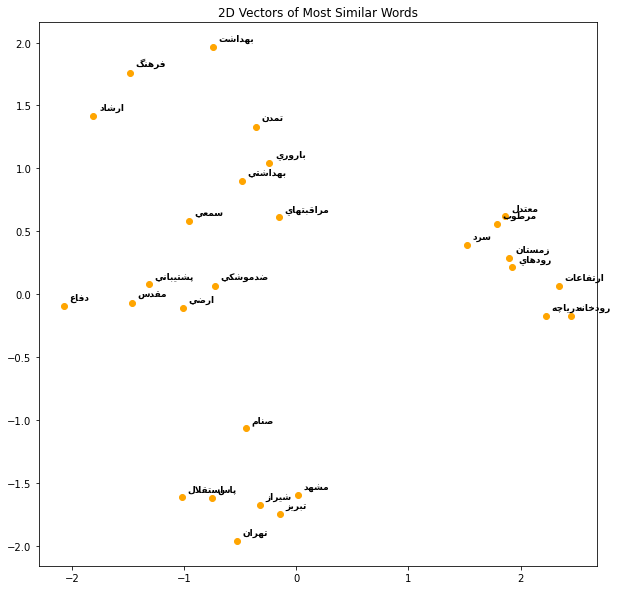

In [245]:
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], color="orange")

for i, word in enumerate(selected_words):
  reshaped_text = arabic_reshaper.reshape(word)
  artext = get_display(reshaped_text)

  plt.text(vectors_2d[i, 0]+0.05, vectors_2d[i, 1]+0.05, artext, fontsize=9, weight="bold")

plt.gcf().set_size_inches(10,10)
plt.title("2D Vectors of Most Similar Words")
plt.show()

In [246]:
pca_3d = PCA(n_components=3)

pca_3d.fit(vectors)

vectors_3d = pca_3d.transform(vectors)

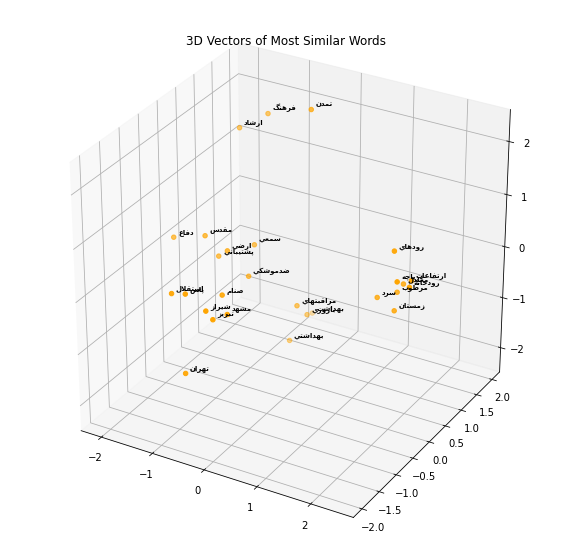

In [247]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], color="orange")

for i, word in enumerate(selected_words):
  reshaped_text = arabic_reshaper.reshape(word)
  artext = get_display(reshaped_text)

  ax.text(vectors_3d[i, 0]+0.05, vectors_3d[i, 1]+0.05, vectors_3d[i, 2]+0.05, artext, fontsize=7, weight="bold")

plt.gcf().set_size_inches(10,10)
plt.title("3D Vectors of Most Similar Words")
plt.show()